In [1]:
!pip install transformers[torch] torchmetrics polars dask


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 23.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 729.2/729.2 kB 31.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 19.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 66.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 34.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.2/244.2 kB 19.6 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import polars as pd
import torch

from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, AutoModelForSequenceClassification

import warnings

warnings.filterwarnings('ignore')

import os
os.environ["TOKENIZERS_PARALLELISM"] = "true"

# model_name = 'bert-base-uncased'
model_name = 'distilbert-base-uncased'
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
path = '/content/drive/MyDrive/ToxicCommentClassificationChallenge/train.csv'
encoded_path = '/content/drive/MyDrive/ToxicCommentClassificationChallenge/train_encoded.npy'
test_path = '/content/drive/MyDrive/ToxicCommentClassificationChallenge/test.csv'
test_encoded_path = '/content/drive/MyDrive/ToxicCommentClassificationChallenge/test_encoded.npy'
model_path = f'models/'
submission_path = 'data/submission.csv'
valid_size = 30_000
epochs=50
batch_size=256 * 2
num_workers=4
num_labels=6
labels_name = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
pred_threshold = 0.5
print_preq = 5
lr=2e-3

os.makedirs('models/', exist_ok=True)
os.makedirs('data/', exist_ok=True)

In [4]:
class CommentDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe, tokenizer, labels=False, encoded=False, max_length=512):
        self.data = dataframe
        self.tokenizer = tokenizer
        self.labels = labels
        self.encoded = encoded
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if self.encoded:
            if self.labels:
                encoding = torch.tensor(self.data.drop(['id','comment_text','toxic','severe_toxic','obscene','threat','insult','identity_hate']).row(idx), dtype=torch.float32)
            else:
                encoding = torch.tensor(self.data.drop(['id','comment_text']).row(idx), dtype=torch.float32)

            sample = {
                'encoding': encoding
            }

        else:
            question = str(self.data.iloc[idx]['comment_text'])

            encoding = self.tokenizer.encode_plus(
                question,
                add_special_tokens=True,
                max_length=self.max_length,
                padding='max_length',
                truncation=True,
                return_tensors='pt'
            )

            input_ids = encoding['input_ids'].squeeze()
            attention_mask = encoding['attention_mask'].squeeze()

            sample = {
                'input_ids': input_ids,
                'attention_mask': attention_mask,
            }

        if self.labels:
            targets = self.data['toxic','severe_toxic','obscene','threat','insult','identity_hate'].row(idx)
            sample['labels'] = torch.tensor(targets, dtype=torch.float32)

        return sample


tokenizer = AutoTokenizer.from_pretrained(model_name)
df = pd.read_csv(path)#.sample(3_000)
# ds = CommentDataset(df, tokenizer)
# data_loader = DataLoader(ds, batch_size=batch_size, shuffle=False, num_workers=num_workers)

base_model = AutoModelForSequenceClassification.from_pretrained(model_name, output_hidden_states=True)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [5]:
from tqdm.auto import tqdm
import numpy as np

def encode(model, data_loader):
    encodings = []
    model.to(device)
    model.eval()
    with torch.no_grad():
        for batch in tqdm(data_loader):
            inputs_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)

            outputs = model(input_ids=inputs_ids, attention_mask=attention_mask)[0]
            hidden_state = outputs.hidden_states[-1].mean(dim=1)
            encodings.extend(hidden_state.cpu().numpy())

    return encodings

# encodings = encode(base_model, data_loader)
encodings = np.load(encoded_path)
encodings = pd.DataFrame(encodings)
df = pd.concat((df, encodings), how='horizontal')
df

id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,column_0,column_1,column_2,column_3,column_4,column_5,column_6,column_7,column_8,column_9,column_10,column_11,column_12,column_13,column_14,column_15,column_16,column_17,column_18,column_19,column_20,column_21,column_22,column_23,column_24,column_25,column_26,column_27,column_28,…,column_731,column_732,column_733,column_734,column_735,column_736,column_737,column_738,column_739,column_740,column_741,column_742,column_743,column_744,column_745,column_746,column_747,column_748,column_749,column_750,column_751,column_752,column_753,column_754,column_755,column_756,column_757,column_758,column_759,column_760,column_761,column_762,column_763,column_764,column_765,column_766,column_767
str,str,i64,i64,i64,i64,i64,i64,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,…,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32
"""0000997932d777…","""Explanation Wh…",0,0,0,0,0,0,0.327372,-0.014544,0.182636,0.075791,0.084792,-0.185277,0.052973,0.251623,0.053839,0.04538,-0.022051,-0.005847,-0.116068,0.061602,0.066662,0.214153,-0.154018,0.096082,0.012201,0.14046,0.184701,0.102895,-0.006494,0.054505,0.109667,0.151376,-0.015585,-0.125174,-0.281163,…,0.274271,-0.15562,0.199235,0.072477,0.124035,0.028206,-0.079578,-0.163613,0.01852,-0.077827,-0.018953,0.022303,-0.154941,-0.117258,-0.081156,-0.009092,0.078452,0.03076,0.024624,-0.074295,-0.102809,0.194072,0.093783,0.032432,-0.041706,-0.134741,-0.162843,0.114359,0.110706,-0.032807,-0.180238,0.177046,-0.115657,-0.077336,0.057821,0.031008,0.037953
"""000103f0d9cfb6…","""D'aww! He matc…",0,0,0,0,0,0,0.012178,-0.023344,0.538176,0.15061,0.247322,-0.113913,0.132581,0.159681,0.056173,-0.068621,-0.10765,-0.130498,0.008365,-0.088068,0.192877,0.201218,-0.102249,0.065134,0.201223,-0.03818,0.268505,0.00352,0.025369,0.173603,0.103585,0.064609,-0.189919,-0.019253,-0.074662,…,0.262164,-0.319549,0.039327,-0.026888,0.031614,-0.091932,-0.131674,0.045126,-0.192221,0.01882,-0.016545,-0.107244,-0.219906,-0.05381,0.05191,-0.118639,-0.0075,0.166254,0.023841,-0.167173,-0.309146,0.233321,0.003787,0.042319,0.001061,-0.199584,-0.403335,-0.025579,0.082865,-0.127884,-0.284205,0.180033,0.031899,0.235131,0.188003,0.231062,0.230229
"""000113f07ec002…","""Hey man, I'm r…",0,0,0,0,0,0,0.220799,0.123037,-0.005348,0.214661,0.109831,-0.219576,-0.052707,0.377739,0.007322,-0.024888,-0.075965,-0.094063,-0.126264,0.032332,0.095772,0.316726,0.148529,0.048216,0.00513,0.135328,0.047464,0.03961,-0.093478,-0.00536,0.127647,-0.027791,0.006424,-0.055303,-0.158919,…,0.143316,-0.067679,0.164661,0.140501,0.19576,-0.099886,-0.230129,-0.188222,0.02538,-0.128037,0.00232,0.139871,-0.124875,-0.124536,0.081231,-0.024491,-0.006007,0.051568,0.072198,-0.153923,-0.094495,0.259815,0.18441,0.156888,0.094175,-0.15506,-0.004735,0.05305,0.00037,-0.027875,-0.181287,0.059103,0.056955,0.067417,0.062287,0.129942,0.033432
"""0001b41b1c6bb3…",""""" More I can't…",0,0,0,0,0,0,0.145261,0.053058,0.350156,0.014427,0.158838,-0.280406,-0.060479,0.288429,-0.014137,-0.032103,-0.123021,-0.074207,-0.064802,0.08882,0.015877,0.260663,-0.005825,0.011003,0.078387,0.063551,0.270261,0.034469,-0.137915,-0.015463,0.326482,-0.06186,0.177291,-0.087678,-0.357545,…,0.089356,-0.151238,0.160036,-0.101827,0.284603,0.019675,-0.067678,-0.186612,0.018401,-0.12463,0.137797,-0.041599,-0.218225,-0.068334,-0.014654,0.084765,0.102227,-0.160167,0.008001,0.058209,-0.173591,0.16011,0.118557,0.157635,-0.027198,-0.37775,-0.020033,0.112626,0.063149,-0.11808,-0.137228,-0.024166,-0.154808,-0.166996,0.040846,0.012791,0.118465
"""0001d958c54c6e…","""You, sir, are …",0,0,0,0,0,0,0.047357,0.031548,0.156182,0.142095,0.298451,-0.197386,0.093833,0.3973,-0.140512,-0.183655,-0.102382,-0.032908,-0.054748,-0.022269,0.180654,0.187703,-0.087904,-0.048277,-0.058177,-0.103174,0.200964,-0.050699,-0.

In [6]:
train, valid = train_test_split(df, test_size=valid_size)
train_ds = CommentDataset(train, tokenizer, labels=True, encoded=True)
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=num_workers)
valid_ds = CommentDataset(valid, tokenizer, labels=True, encoded=True)
valid_loader = DataLoader(valid_ds, batch_size=batch_size, shuffle=False, num_workers=num_workers)

In [7]:
class MultiHeadClassifier(torch.nn.Module):
    def __init__(self, drop_prop=0.2, num_labels=num_labels):
        super(MultiHeadClassifier, self).__init__()

        self.fc = torch.nn.Sequential(
            torch.nn.Dropout(drop_prop),
            torch.nn.Linear(768, 768),
            torch.nn.Dropout(drop_prop),
            torch.nn.Linear(768, num_labels),
        )

    def forward(self, x):
        return self.fc(x)


model = MultiHeadClassifier()

In [ ]:
from torchmetrics import F1Score, AUROC
from tqdm import tqdm


def train(model, optimizer, criterion, weights, train_loader, valid_loader, lr_scheduler=None, model_name='model',
          epochs=epochs, valid_f1_max=0, device=device):

      check_f1 = [float(el.split('_')[-2]) for el in os.listdir(model_path) if el.startswith(model_name)]
      if check_f1:
            valid_f1_max = max(check_f1)
      f1score = F1Score(task='multilabel', threshold=pred_threshold, num_labels=num_labels, average='macro').to(device)
      auroc = AUROC(task='multilabel', num_labels=num_labels, average='macro').to(device)
      model.to(device)
      weights = weights.to(device)
      model.train()

      epoch_train_loss = []
      epoch_train_f1 = []
      epoch_train_auroc = []
      epoch_valid_loss = []
      epoch_valid_f1 = []
      epoch_valid_auroc = []
      epoch_lr = []
      for e in range(epochs):
            train_loss = 0
            train_f1 = 0
            train_auroc = 0

            for batch in tqdm(train_loader, leave=False):
                  encodings = batch['encoding'].to(device)
                  labels = batch['labels'].to(device)

                  outputs = model(encodings)
                  loss = criterion(outputs, labels)
                  loss = (loss * weights).mean()

                  optimizer.zero_grad()
                  loss.backward()
                  optimizer.step()

                  train_loss += loss.detach().cpu().numpy()
                  train_f1 += f1score(outputs, labels).detach().cpu().numpy()
                  train_auroc += auroc(outputs, labels.to(torch.int64)).detach().cpu().numpy()

            train_loss /= len(train_loader)
            train_f1 /= len(train_loader)
            train_auroc /= len(train_loader)

            epoch_train_loss.append(train_loss)
            epoch_train_f1.append(train_f1)
            epoch_train_auroc.append(train_auroc)

            model.eval()
            valid_loss = 0
            valid_f1 = 0
            valid_auroc = 0

            with torch.no_grad():
                  for batch in tqdm(valid_loader, leave=False):
                        encodings = batch['encoding'].to(device)
                        labels = batch['labels'].to(device)

                        outputs = model(encodings)
                        loss = criterion(outputs, labels)
                        loss = (loss * weights).mean()

                        valid_loss += loss.detach().cpu().numpy()
                        valid_f1 += f1score(outputs, labels).detach().cpu().numpy()
                        valid_auroc += auroc(outputs, labels.to(torch.int64)).detach().cpu().numpy()

            valid_loss /= len(valid_loader)
            valid_f1 /= len(valid_loader)
            valid_auroc /= len(valid_loader)

            epoch_valid_loss.append(valid_loss)
            epoch_valid_f1.append(valid_f1)
            epoch_valid_auroc.append(valid_auroc)

            if (e + 1) % print_preq == 0:
                print(f'Epoch {e + 1}/{epochs}: train_loss {train_loss:.3f} train_f1 {train_f1:.3f} train_auroc {train_auroc:.3f} valid_loss {valid_loss:.3f} valid_f1 {valid_f1:.3f} valid_auroc {valid_auroc:.3f}')

            if valid_f1 > valid_f1_max:
                  valid_f1_max = valid_f1
                  torch.save(model, os.path.join(model_path, f'{model_name}_{valid_f1:.3f}_.pth'))

            lr_scheduler.step(valid_f1)
            epoch_lr.append(optimizer.param_groups[0]["lr"])

      return {
            'train_loss': epoch_train_loss,
            'train_f1': epoch_train_f1,
            'train_auroc': epoch_train_auroc,
            'valid_loss': epoch_valid_loss,
            'valid_f1': epoch_valid_f1,
            'valid_auroc': epoch_valid_auroc,
            'lr': epoch_lr
      }

optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
criterion = torch.nn.BCEWithLogitsLoss(reduction='none')
weights = torch.tensor([0.2, 0.75, 0.2, 1.0, 0.3, 0.85])
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=5, min_lr=1e-5)
callbacks = train(model, optimizer, criterion, weights, train_loader, valid_loader, lr_scheduler=lr_scheduler, epochs=25)

 89%|████████▉ | 227/254 [00:55<00:05,  4.61it/s]

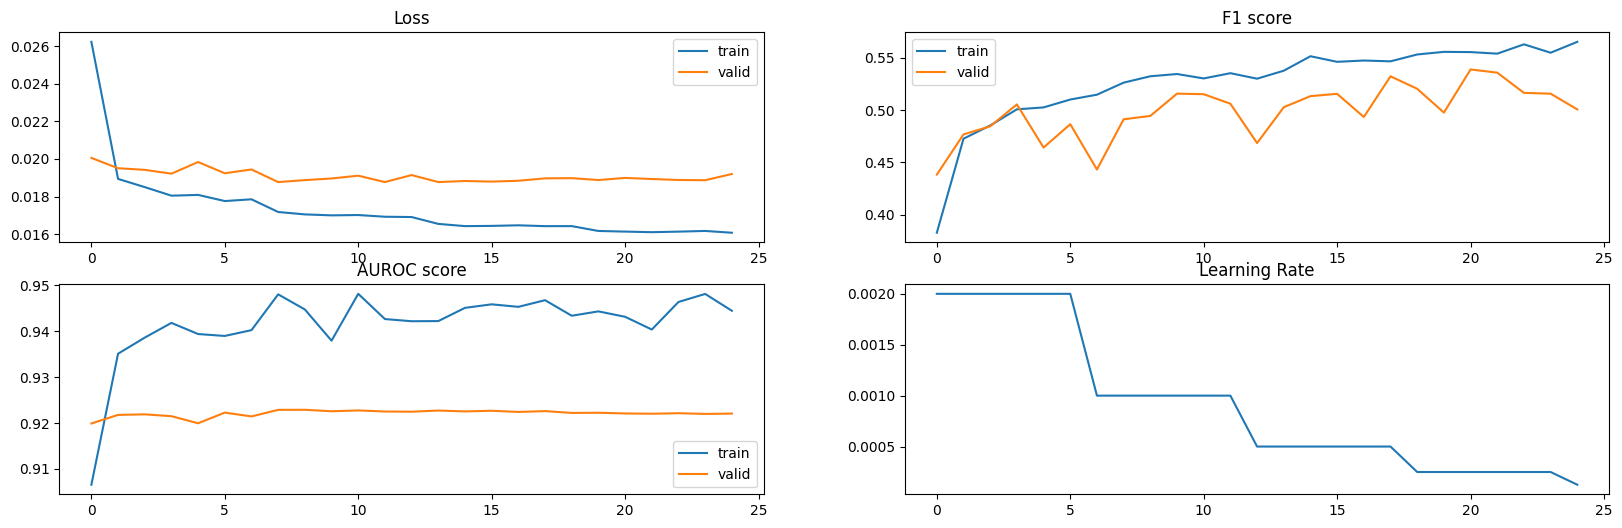

In [9]:
import matplotlib.pyplot as plt

def monitor(callbacks):
    fig, ax = plt.subplots(2, 2, figsize=(20, 6))
    ax[0][0].plot(callbacks['train_loss'], label='train')
    ax[0][0].plot(callbacks['valid_loss'], label='valid')
    ax[0][0].legend()
    ax[0][0].set_title('Loss')

    ax[0][1].plot(callbacks['train_f1'], label='train')
    ax[0][1].plot(callbacks['valid_f1'], label='valid')
    ax[0][1].legend()
    ax[0][1].set_title('F1 score')


    ax[1][0].plot(callbacks['train_auroc'], label='train')
    ax[1][0].plot(callbacks['valid_auroc'], label='valid')
    ax[1][0].legend()
    ax[1][0].set_title('AUROC score')


    ax[1][1].plot(callbacks['lr'])
    ax[1][1].set_title('Learning Rate')

    plt.show()

monitor(callbacks)

In [10]:
import shutil

source_folder_path = '/content/models'
destination_folder_path = '/content/drive/MyDrive/ToxicCommentClassificationChallenge/models'
if os.path.exists(destination_folder_path):
    shutil.rmtree(destination_folder_path)
shutil.copytree(source_folder_path, destination_folder_path)

'/content/drive/MyDrive/ToxicCommentClassificationChallenge/models'

100%|██████████| 59/59 [00:11<00:00,  5.08it/s]


               precision    recall  f1-score   support

        toxic       0.89      0.59      0.71      2979
 severe_toxic       0.55      0.27      0.36       311
      obscene       0.87      0.61      0.72      1613
       threat       0.61      0.38      0.47        89
       insult       0.80      0.51      0.62      1507
identity_hate       0.63      0.28      0.39       276

    micro avg       0.84      0.55      0.66      6775
    macro avg       0.72      0.44      0.54      6775
 weighted avg       0.84      0.55      0.66      6775
  samples avg       0.05      0.05      0.05      6775



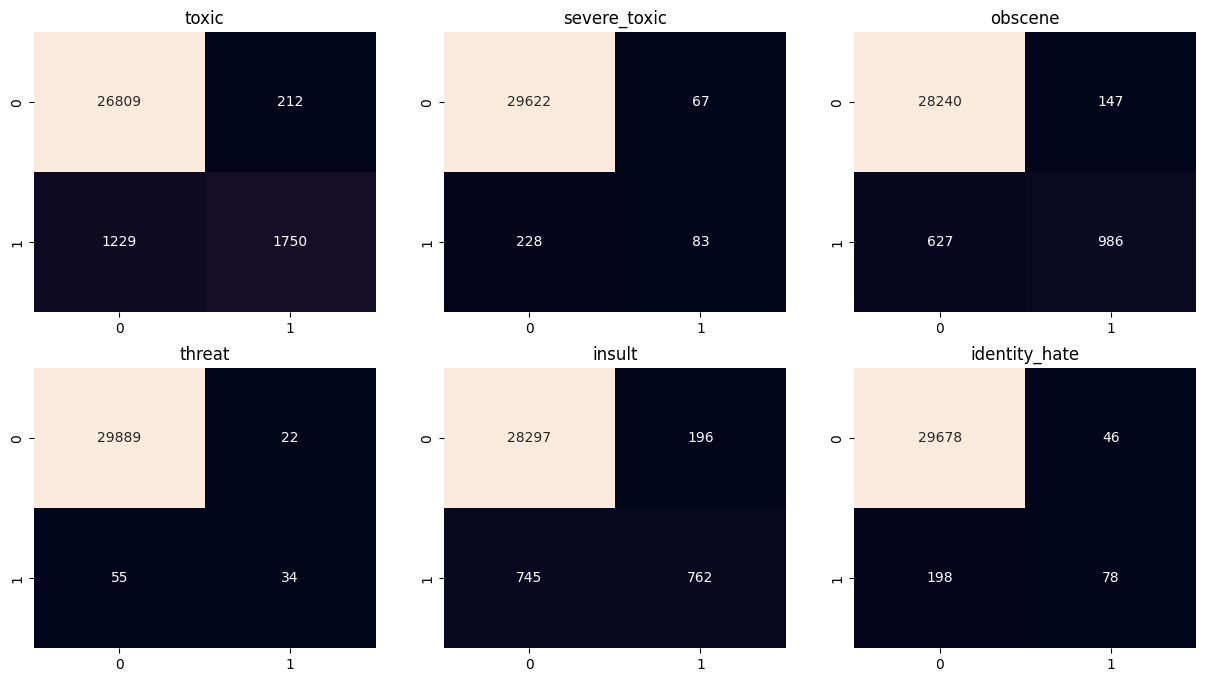

In [11]:
from sklearn.metrics import classification_report, multilabel_confusion_matrix
import seaborn as sns

def inference(model, data_loader, threshold=pred_threshold, evaluate=False):
    predictions = []
    labels = []
    model.to(device)
    model.eval()
    with torch.no_grad():
        for batch in tqdm(data_loader):
            encodings = batch['encoding'].to(device)

            outputs = model(encodings)
            preds = (outputs > threshold).to(torch.int64)

            predictions.extend(preds.cpu().numpy())
            if evaluate:
                labels.extend(batch['labels'].numpy())

    if evaluate:
        print(classification_report(labels, predictions, target_names=labels_name))
        multi_cm = multilabel_confusion_matrix(labels, predictions)
        plt.figure(figsize=(15, 8))
        for i, cm in enumerate(multi_cm):
            ax = plt.subplot(2, 3, i + 1)
            sns.heatmap(cm, annot=True, fmt='g', cbar=False, ax=ax)
            ax.set_title(labels_name[i])
        plt.show()

    return predictions, labels


best_model_path = os.listdir(model_path)[np.argmax([float(el.split('_')[-2]) for el in os.listdir(model_path)])]
best_model = torch.load(os.path.join(model_path, best_model_path))
preds, lebs = inference(best_model, valid_loader, threshold=0.5, evaluate=True)

In [ ]:
test_df = pd.read_csv(test_path)#.sample(3_000)

test_encodings = np.load(test_encoded_path)
test_encodings = pd.DataFrame(test_encodings)
test_df = pd.concat((test_df, test_encodings), how='horizontal')

test_ds = CommentDataset(test_df, tokenizer, encoded=True)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=num_workers)

predictions = inference(model, test_loader)[0]

submission = pd.DataFrame(predictions, schema=labels_name)
submission = pd.concat((test_df[['id']], submission), how='horizontal')
submission.write_csv(submission_path)
submission

In [13]:
source_folder_path = submission_path
destination_folder_path = '/content/drive/MyDrive/ToxicCommentClassificationChallenge/submission.csv'
if os.path.exists(destination_folder_path):
    shutil.rmtree(destination_folder_path)
shutil.copy(source_folder_path, destination_folder_path)

NotADirectoryError: ignored